#### Files
##### train.csv
* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

##### building_meta.csv
* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

##### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

##### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [3]:
df_test = pd.read_csv("datasets/test_merge.csv")

In [4]:
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 1988.30 Mb (63.2% reduction)


In [5]:
df_test.shape

(41697600, 17)

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
Unnamed: 0            int32
row_id                int32
building_id           int16
meter                 int8
timestamp             object
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), int16(1), int32(3), int8(2), object(2)
memory usage: 1.9+ GB


In [7]:
df_test.head()

,Unnamed: 0,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [8]:
df_test.isnull().sum(axis = 0)

Unnamed: 0                   0
row_id                       0
building_id                  0
meter                        0
timestamp                    0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature         221901
cloud_coverage        19542180
dew_temperature         260799
precip_depth_1_hr      7801563
sea_level_pressure     2516826
wind_direction         2978663
wind_speed              302089
dtype: int64

In [9]:
# nan_values={'air_temperature':np.around(np.mean(df_test['air_temperature']),decimals=1),'cloud_coverage':np.around(np.mean(df_test['cloud_coverage'])),'dew_temperature':np.around(np.mean(df_test['dew_temperature']),decimals=1),'precip_depth_1_hr':np.around(np.mean(df_test['precip_depth_1_hr'])),'sea_level_pressure':np.around(np.mean(df_test['sea_level_pressure'])),'wind_direction':np.around(np.mean(df_test['wind_direction'])),'wind_speed':np.around(np.mean(df_test['wind_speed']))}
# df_test=df_test.fillna(value=nan_values)

In [10]:
df_test.isnull().sum(axis = 0)

Unnamed: 0                   0
row_id                       0
building_id                  0
meter                        0
timestamp                    0
site_id                      0
primary_use                  0
square_feet                  0
year_built            24598080
floor_count           34444320
air_temperature         221901
cloud_coverage        19542180
dew_temperature         260799
precip_depth_1_hr      7801563
sea_level_pressure     2516826
wind_direction         2978663
wind_speed              302089
dtype: int64

In [11]:
print(df_test['meter'].unique())
df_test['meter'].value_counts()

[0 1 3 2]


0    24755760
1     8724960
2     5676480
3     2540400
Name: meter, dtype: int64

0    59.369748
1    20.924370
2    13.613445
3     6.092437
Name: meter, dtype: float64


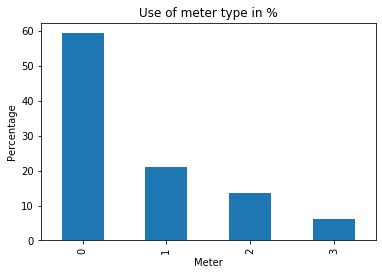

In [12]:
meter_percent = df_test.meter.value_counts('percent')*100
print(meter_percent)
meter_percent.plot(kind='bar')
plt.title("Use of meter type in %")
plt.ylabel("Percentage")
plt.xlabel("Meter")
plt.show()

In [13]:
print(df_test['site_id'].unique())
df_test['site_id'].value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


13    5413680
9     5361120
2     5063280
14    5045760
3     4800480
15    4380000
0     2260080
4     1594320
5     1559280
6     1401600
8     1226400
1     1103760
10     876000
7      735840
12     630720
11     245280
Name: site_id, dtype: int64

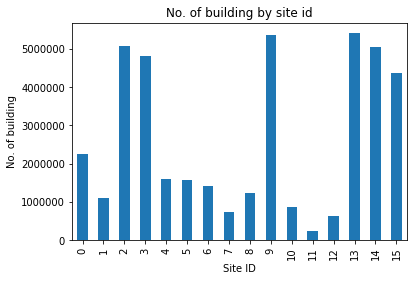

In [14]:
df_test.groupby('site_id')['building_id'].count().plot(kind='bar')
plt.title("No. of building by site id")
plt.ylabel("No. of building")
plt.xlabel("Site ID")
plt.show()

['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']
Education                        16801680
Office                            9005280
Entertainment/public assembly     4712880
Lodging/residential               4502640
Public services                   3416400
Healthcare                         805920
Other                              508080
Parking                            438000
Manufacturing/industrial           262800
Retail                             227760
Warehouse/storage                  227760
Food sales and service             227760
Services                           192720
Technology/science                 175200
Utility                            122640
Religious worship                   70080
Name: primary_use, dtype: int64


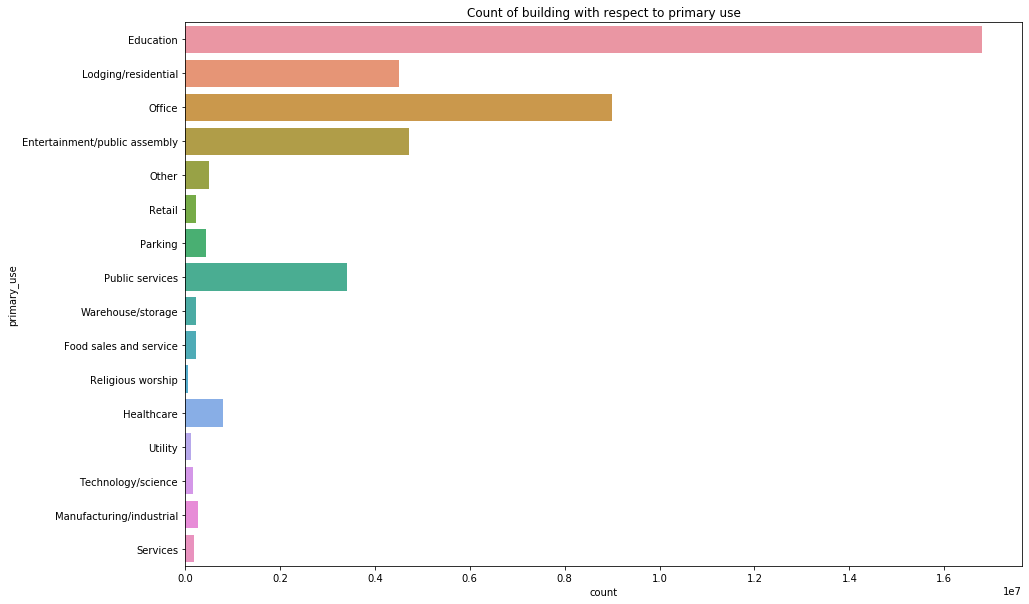

In [15]:
print(df_test['primary_use'].unique())
print(df_test['primary_use'].value_counts())
plt.figure(figsize=(15,10))
sns.countplot(y='primary_use',data=df_test)
plt.title("Count of building with respect to primary use")
plt.show()

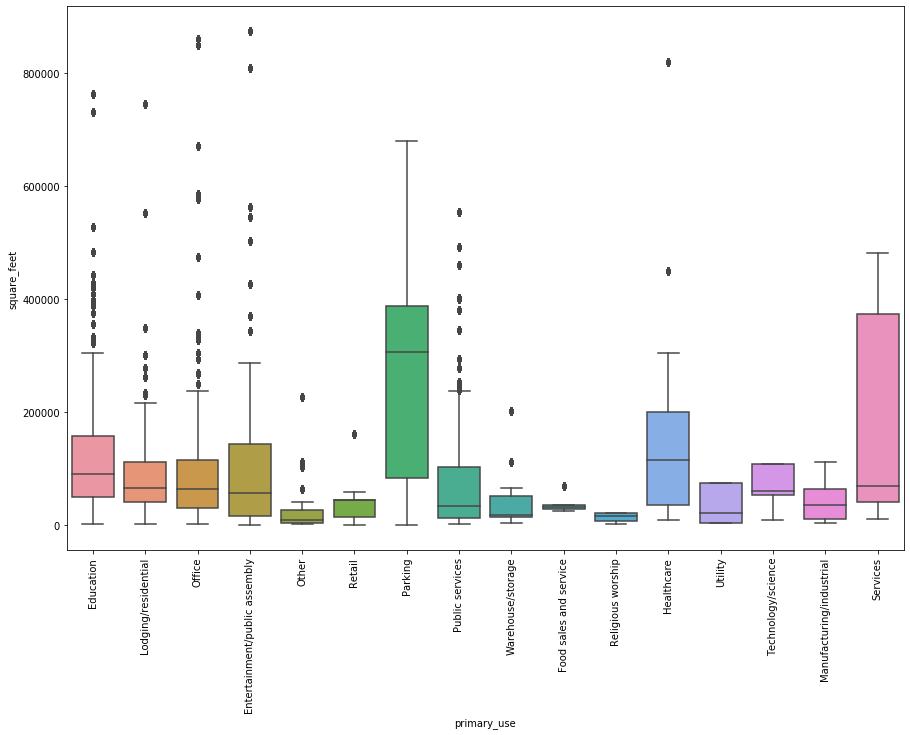

In [16]:
plt.figure(figsize=(15,10))
sns.boxplot(x='primary_use', y='square_feet', data=df_test)
plt.xticks(rotation=90)
plt.show()

[2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2006.
 2014. 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1932. 1978. 1912. 1916. 1924. 1926. 1904.
 1984. 1903. 1925. 1961. 1921. 1972. 1936. 1954. 1905. 1920. 1917. 1952.
 1994. 1933. 1945. 1938. 1915. 1947. 1946. 1902. 1937.]
1976.0    1068720
1964.0     525600
1966.0     455520
2006.0     420480
1975.0     402960
           ...   
1972.0      17520
1936.0      17520
1905.0      17520
1944.0      17520
2017.0      17520
Name: year_built, Length: 116, dtype: int64


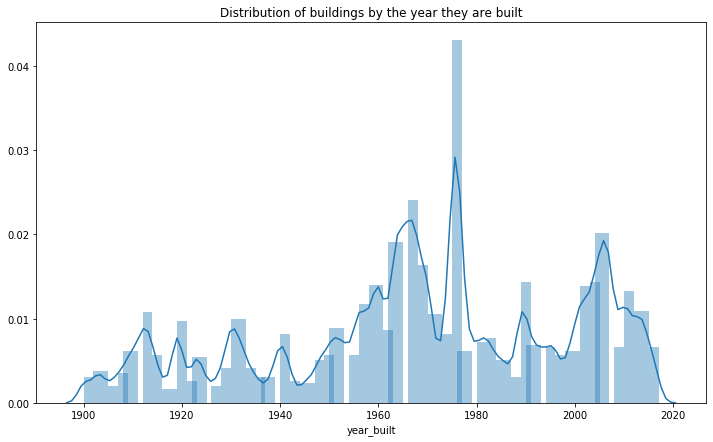

In [17]:
print(df_test['year_built'].unique())
print(df_test['year_built'].value_counts())
plt.figure(figsize=(12,7))
sns.distplot(df_test['year_built'].dropna())
plt.title('Distribution of buildings by the year they are built')
plt.show()

/home/jakesh/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jakesh/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


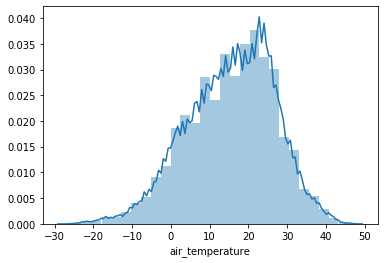

In [18]:
sns.distplot(df_test['air_temperature'], hist=True, kde=True,bins=30)

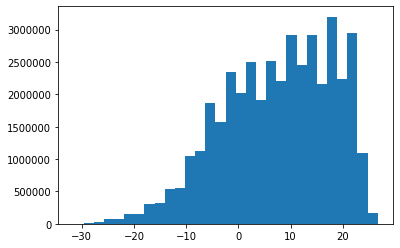

In [19]:
plt.hist(df_test['dew_temperature'], bins=30)
plt.show()

In [21]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","year_built","Unnamed: 0","year_built","floor_count"]


In [22]:
df_test = df_test.drop(drop_cols, axis = 1)

In [23]:
df_test.to_csv("datasets/ashrae-energy-prediction/test_final.csv")

#### 